In [1]:
import qiskit
import qiskit_machine_learning as qml
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA, SNOBFIT
from qiskit.circuit import Parameter, ParameterExpression, ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels.parameterized_quantum_kernel import ParamQuantumKernel
from qiskit_machine_learning.kernels import QuantumKernel

from qiskit_machine_learning.algorithms import QSVC
from qiskit.aqua.operators import StateFn, Z, ListOp


from qiskit import QuantumCircuit, Aer
from qiskit.aqua import QuantumInstance

import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial,reduce
import numpy as np
import copy
from copy import deepcopy as dc

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operators/operator_globals.py:48: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))


# First Build a Parameterized Feature Map

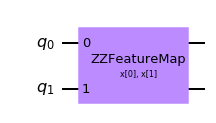

In [70]:
# Define a (non-parameterized) feature map
fm = ZZFeatureMap(2)
input_params = fm.parameters
fm.draw('mpl')

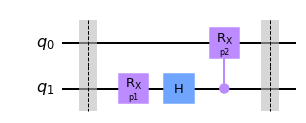

In [71]:
# Define a tunable sub-circuit
W = QuantumCircuit(2)
p1 = Parameter('p1')
p2 = Parameter('p2')
W.barrier()
W.rx(p1, 1)
W.h(1)
W.crx(p2, 1, 0)
W.barrier()
W.draw(output='mpl')

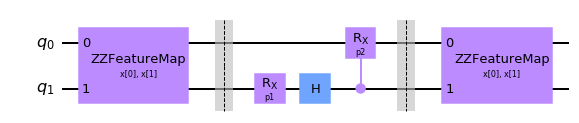

In [72]:
# Compose them to build a parameterized feature map
pfm = fm.compose(W).compose(fm)#.decompose()
pfm.draw(output='mpl')

# Build an Ad-hoc dataset

In [73]:
N = 20
X = np.random.rand(20,2)
free_params = [p1,p2]
true_free_vals = [0.4, 1.9]
true_free_bindings = {p:v for (p,v) in zip(free_params, true_free_vals)}

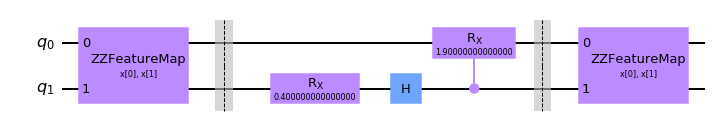

In [74]:
# fm is no longer parameterized, because we have bound values to the free parameters
fm = pfm.bind_parameters(true_free_bindings)
fm.draw('mpl')

In [79]:
# This expression is basically just encoding that after I prepare my feature state
# I want to measure the Pauli Z observable on both qubits. 
fm_op = ~StateFn(Z^Z) @ StateFn(fm) 

# This operator will generate a number between [-1,+1] for each entry in X.
# It is essentially looping over X, binding each entry of X to the 
# input parameters of our feature map. And it is doing this once for each
# entry of X. So we end up with len(X) copies of our feature map, all with different
# inputs bound to them.
y_op = ListOp([fm_op.bind_parameters({p:v for (p,v) in zip(input_params, xi)}) for xi in X])

In [88]:
# These inner products are always real numbers, and we only really care
# about taking their sign.
y  = np.sign(np.real(y_op.eval()))
print(y)

[ 1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.
  1. -1.]


In [96]:
print('X = ', X)
print('y = ', y)

X =  [[0.87066548 0.23697428]
 [0.52364449 0.47706078]
 [0.32718564 0.51158733]
 [0.43386909 0.72681197]
 [0.59590169 0.34661481]
 [0.78407227 0.56597119]
 [0.70649154 0.04683843]
 [0.87202885 0.33911793]
 [0.51624376 0.1003674 ]
 [0.38034726 0.97704455]
 [0.20969548 0.65264124]
 [0.30453891 0.68698161]
 [0.3747999  0.36513099]
 [0.06393683 0.65391511]
 [0.06572619 0.97577677]
 [0.33144918 0.66283208]
 [0.37766754 0.73989033]
 [0.32389965 0.69802172]
 [0.21252023 0.91567623]
 [0.81769783 0.89928094]]
y =  [ 1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.
  1. -1.]


In [105]:
pfm.decompose().draw()

┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                           ░ ┌─────────┐»
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■───░─┤ U1(π/2) ├»
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐ ░ ├─────────┤»
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├─░─┤ R(p1,0) ├»
«     └─────────────┘└───┘└──────────────────────────────┘└───┘ ░ └─────────┘»
«                ┌───┐┌─────────────────┐┌───┐┌─────────────────┐ ░ ┌───┐»
«q_0: ───────────┤ X ├┤ U3(-0.5*p2,0,0) ├┤ X ├┤ U3(p2/2,-π/2,0) ├─░─┤ H ├»
«     ┌─────────┐└─┬─┘└─────────────────┘└─┬─┘└─────────────────┘ ░ ├───┤»
«q_1: ┤ U2(0,π) ├──■───────────────────────■──────────────────────░─┤ H ├»
«     └─────────┘                                                 ░ └───┘»
«     ┌─────────────┐                                          ┌───┐»
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
«     └─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘

In [103]:
pfm.parameters

ParameterView([Parameter(p1), Parameter(p2), ParameterVectorElement(x[0]), ParameterVectorElement(x[1])])

In [106]:
free_params = [p1,p2]
true_free_vals = [0.4, 1.9]
true_free_bindings = {p:v for (p,v) in zip(free_params, true_free_vals)}

In [107]:
fm = pfm.bind_parameters(true_free_bindings)


In [110]:
print(fm.parameters)

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1])])


In [112]:
fm = QuantumCircuit(n_qubits)
...
...

# Future Usage
#--------------
fm = CovariantFeatureMap(n_qubits)
free_params = fm.free_params
input_params = fm.inputs_params

#---
assert input_params + free_params == fm.parameters


pqk = PQK(fm, free_params)

NameError: name 'n_qubits' is not defined